# ZNE

In [2]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_channel import *
from quantum_tools import *
from experimental import *
from spam import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
def global_folding(circuit_target, fold=0):
    circuit = circuit_target.copy()
    circuit = qk.QuantumCircuit(circuit.num_qubits).compose(circuit)
    for i in range(fold):
        circuit.barrier()
        circuit_fold1 = circuit_target.inverse().copy()
        circuit_fold1.barrier()
        circuit_fold2 = circuit_target.copy()
        
        circuit = circuit.compose(circuit_fold1.compose(circuit_fold2))
    
    circuit.add_register(qk.ClassicalRegister(circuit.num_qubits))
    circuit.measure(circuit.qregs[0], circuit.cregs[0])
    
    return circuit

def local_folding(circuit_target, fold=0):
    circuit = circuit_target.copy()
    circuit = qk.QuantumCircuit(circuit.num_qubits).compose(circuit)
    for i in range(fold):
        circuit.barrier()
        circuit_fold1 = circuit_target.inverse().copy()
        circuit_fold1.barrier()
        circuit_fold2 = circuit_target.copy()
        
        circuit = circuit.compose(circuit_fold1.compose(circuit_fold2))
    
    circuit.add_register(qk.ClassicalRegister(circuit.num_qubits))
    circuit.measure(circuit.qregs[0], circuit.cregs[0])
    
    return circuit

In [88]:
np.random.seed(43)
random.seed(43)
n = 3

circuit_target = variational_circuit(n, 2, 0, 2).reverse_bits()
circuit_fold0 = global_folding(circuit_target, fold=0)
circuit_fold1 = global_folding(circuit_target, fold=1)
circuit_fold2 = global_folding(circuit_target, fold=2)
circuit_fold3 = global_folding(circuit_target, fold=3)
circuit_fold4 = global_folding(circuit_target, fold=4)
circuit_fold5 = global_folding(circuit_target, fold=5)

circuit_list = [circuit_fold0, circuit_fold1, circuit_fold2, circuit_fold3, circuit_fold4, circuit_fold5]

In [89]:
job = qk.execute(circuit_list, backend, shots = 20000, optimization_level = 0, seed_transpiler=42)
result = job.result()
counts_list = [result.get_counts(circuit) for circuit in circuit_list]

In [90]:
probs = counts_to_probs(counts_list).numpy()

In [91]:
pickle.dump(probs, open(f"../../data/ZNE_three_qubit.p", "wb"))  

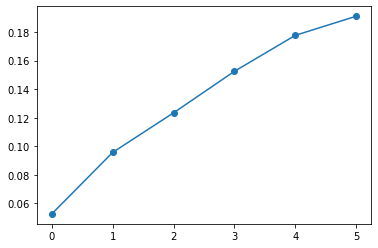

In [93]:
plt.plot(probs[:,0],"-o")

## ZNE

In [8]:
n = 3
d = 2**n

c_list = np.linspace(0.001, 0.999, 100)
state = np.zeros((1, 8, 8))
state[0, 0, 0] = 1               
state_input = tf.convert_to_tensor(state, dtype=precision)

output_list = []
rank_eff_list = []

for c in tqdm(c_list):
    np.random.seed(41)
    random.seed(41)
    tf.random.set_seed(41)

    U = generate_unitary(d=d)

    kraus_model = DilutedKrausMap(U = U,
                                  c = c,
                                  d = d, 
                                  rank = int((1-c)*d**2+1),
                                 )
    
    output_list.append(kraus_model.apply_channel(state_input)[0,1,1].numpy())
    rank_eff_list.append(effective_rank(kraus_model))

  0%|          | 0/100 [00:00<?, ?it/s]

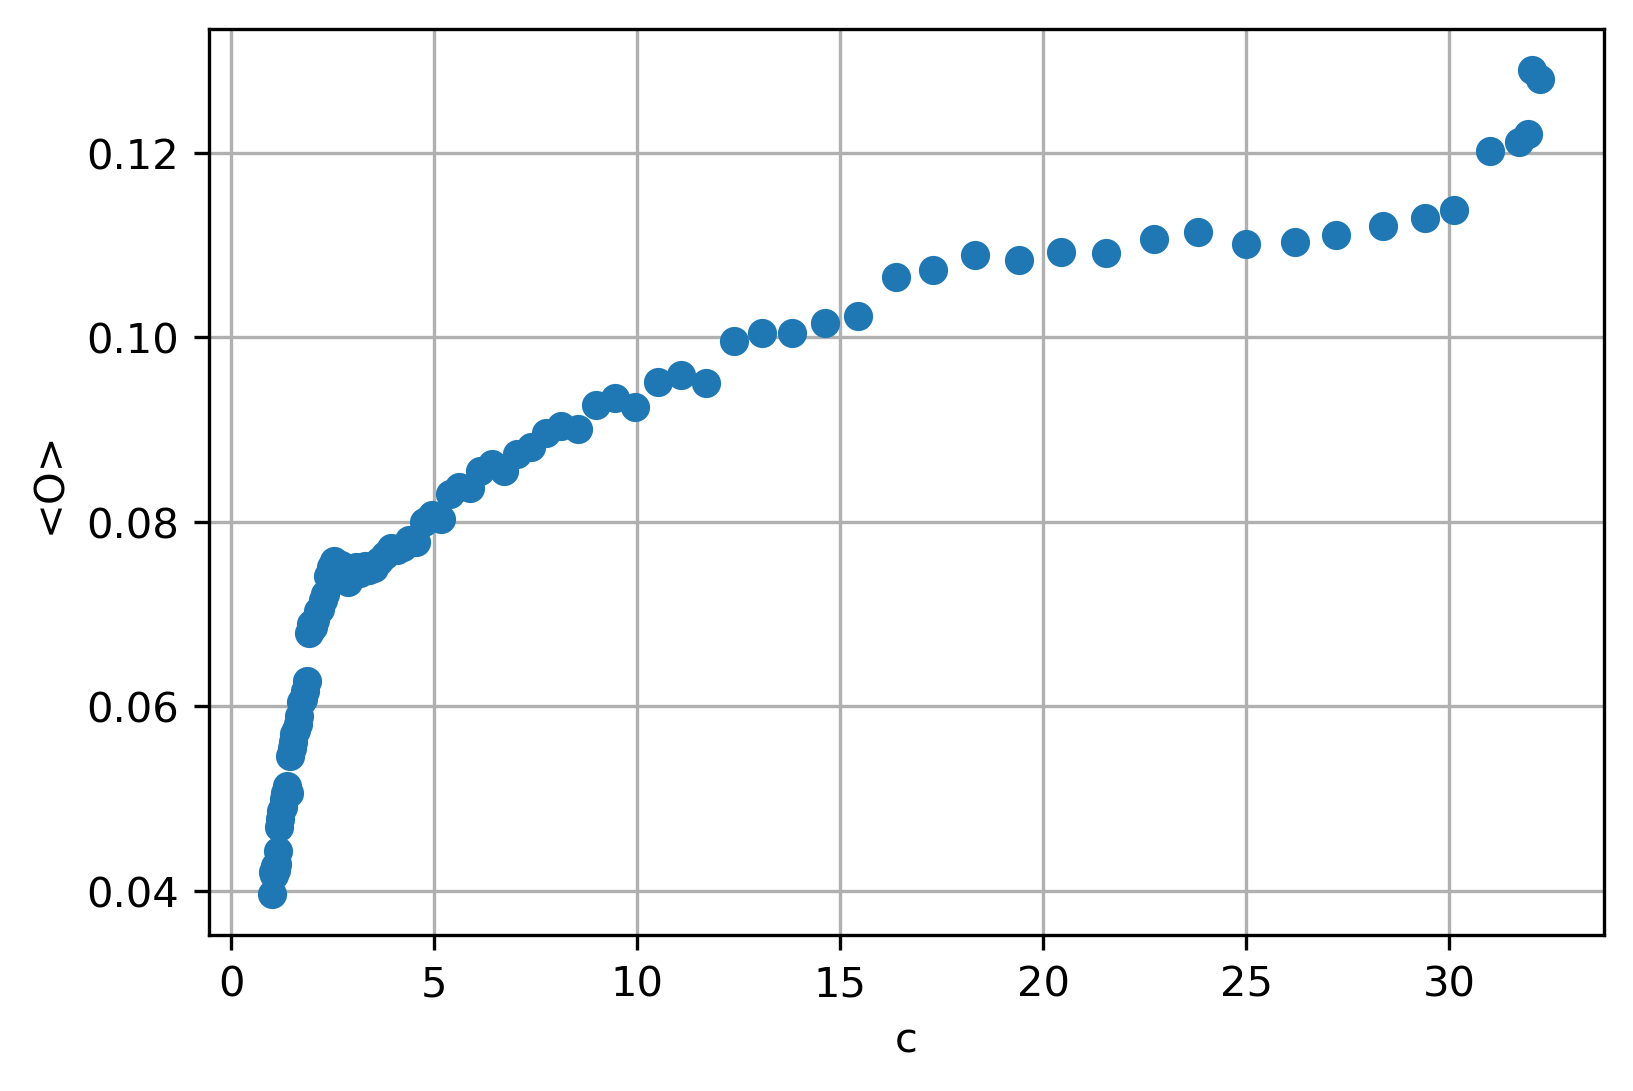

In [9]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.plot(rank_eff_list, output_list, 'o')
plt.xlabel("c")
plt.ylabel("<O>")
plt.grid()
plt.show()